# This is a small demo on how to use Points2Region

First we will download some data. The .CSV file is roughly 10MB. Downloading might take some time. You can interactivly explore the data [here](https://tissuumaps.dckube.scilifelab.se/demo.tmap?path=private/Points2Regions)

In [1]:
import pandas as pd
data = pd.read_csv(r'https://tissuumaps.dckube.scilifelab.se/private/Points2Regions/toy_data.csv')
data

,X,Y,Genes
0,20235,15181,Gad1
1,20903,10746,Aldoc
2,25038,11291,Fam19a1
3,9277,2059,Aldoc
4,6017,5267,Atp1b1
...,...,...,...
499995,16221,13595,Tmsb10
499996,15112,16609,Vsnl1
499997,21493,11624,Pcp4
499998,25023,10545,Cplx2


Let's plot the data

(-828.5500000000002, 34911.55, -1115.0, 23547.0)

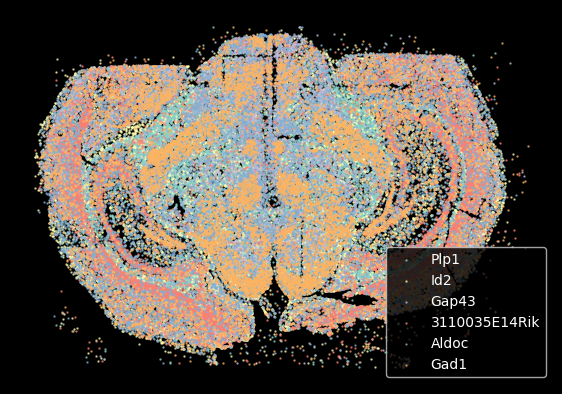

In [2]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

genes_to_plot = ['Plp1', 'Id2', 'Gap43', '3110035E14Rik', 'Aldoc', 'Gad1']

plt.figure(figsize=(7,7))
for gene in genes_to_plot:
    data_by_gene = data.query('Genes == @gene')
    plt.scatter(data_by_gene['X'], data_by_gene['Y'], label=gene, alpha=0.7, s=0.5)
plt.legend()
plt.axis('off')
plt.axis('scaled')

Let's cluster the data ...

In [3]:
from points2regions import Points2Regions
# Create Points2Region instance
mdl = Points2Regions(
    data[['X','Y']], 
    data['Genes'], 
    pixel_width=1, 
    pixel_smoothing=200
)

# Get the clusters per marker
data['Clusters']  = mdl.fit_predict(num_clusters=15, output='marker')


... and plot

(6901.1, 9098.9, 9951.1, 11048.9)

c:\Users\axela\anaconda3\envs\iss_decoding\lib\site-packages\IPython\core\events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\axela\anaconda3\envs\iss_decoding\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


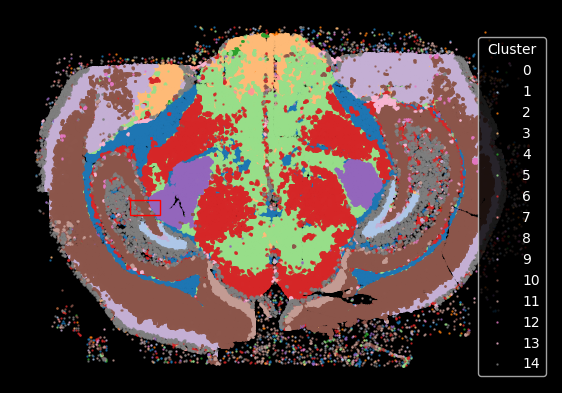

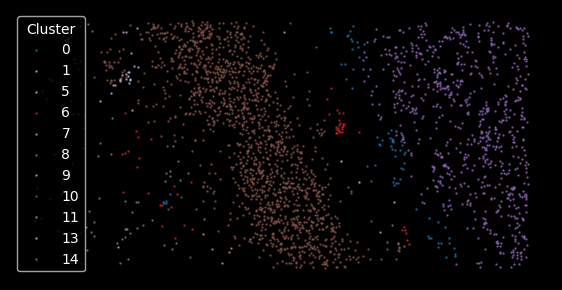

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
plt.style.use('dark_background')

# Zoomed in ROI
X_MIN, Y_MIN, X_MAX, Y_MAX = 7000, 10000, 9000, 11000


colors = sns.color_palette("tab20")

# Big plot
plt.figure(figsize=(7,7))
for cluster, data_by_cluster in data.groupby('Clusters'):
    plt.scatter(data_by_cluster['X'], data_by_cluster['Y'], label=str(cluster), alpha=0.7, s=0.5, color=colors[cluster])

plt.gca().add_patch(Rectangle((X_MIN, Y_MIN), X_MAX - X_MIN, Y_MAX - Y_MIN, edgecolor = 'red', fill=False, lw=1))

plt.legend(title='Cluster')
plt.axis('off')
plt.axis('scaled')


# Zoomed in
plt.figure(figsize=(7,7))
for cluster, data_by_cluster in data.query('X > @X_MIN and X < @X_MAX and Y > @Y_MIN and Y < @Y_MAX').groupby('Clusters'):
    plt.scatter(data_by_cluster['X'], data_by_cluster['Y'], label=str(cluster), alpha=0.7, s=0.5, color=colors[cluster])
plt.legend(title='Cluster')
plt.axis('off')
plt.axis('scaled')



Let's run with different smoothing

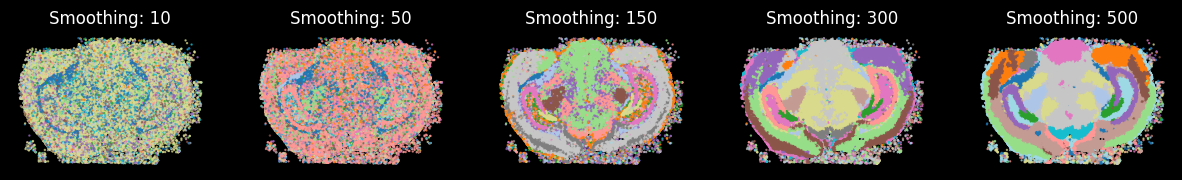

In [5]:
smoothings = [10, 50, 150, 300, 500]
n = len(smoothings)

plt.figure(figsize=(3*n, 3))
for i, smoothing in enumerate(smoothings):
    # Extract features
    data['Clusters']  = Points2Regions(data[['X','Y']], data['Genes'], pixel_width=1, pixel_smoothing=smoothing)\
        .fit_predict(num_clusters=15, output='marker')
    
    # Plot the clusters
    data_by_cluster = data.query('Clusters != -1')

    plt.subplot(1, n, i+1)
    plt.scatter(
        data_by_cluster['X'], 
        data_by_cluster['Y'], 
        c=data_by_cluster['Clusters'], 
        alpha=0.7, 
        s=0.5, 
        cmap='tab20'
    )
    plt.title(f'Smoothing: {smoothing}')
    plt.axis('off')
    plt.axis('scaled')

Let's run with different number of clusters

Initializing ...
Clustering with number of clusters: 2 ...
Clustering with number of clusters: 4 ...
Clustering with number of clusters: 8 ...
Clustering with number of clusters: 16 ...
Clustering with number of clusters: 20 ...
Clustering with number of clusters: 100 ...


c:\Users\axela\anaconda3\envs\iss_decoding\lib\site-packages\sklearn\cluster\_kmeans.py:2092: RuntimeWarning: init_size=100 should be larger than n_clusters=175. Setting it to min(3*n_clusters, n_samples)
  self._check_params_vs_input(X)


Plotting ...


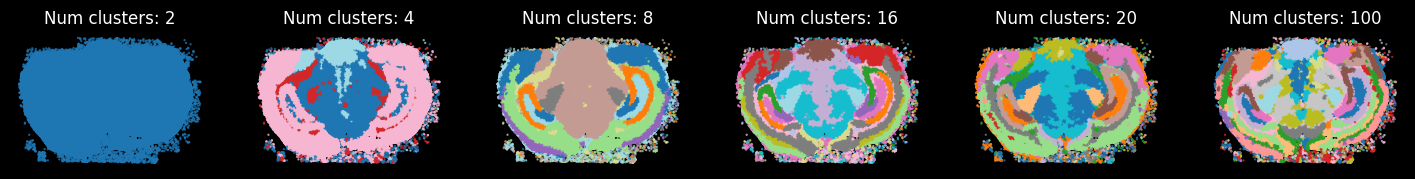

In [6]:
num_clusters = [2,4,8,16,20,100]
n = len(num_clusters)
print('Initializing ...')
mdl = Points2Regions(data[['X','Y']], data['Genes'], pixel_width=1, pixel_smoothing=500)
clusters = []

for i, num_cluster in enumerate(num_clusters):
    print(f'Clustering with number of clusters: {num_cluster} ...')
    clusters.append(mdl.fit_predict(num_cluster, output='marker'))


print('Plotting ...')
plt.figure(figsize=(3*n, 3))
for i, num_cluster in enumerate(num_clusters):
    plt.subplot(1, n, i+1)
    plt.scatter(
        data['X'], 
        data['Y'], 
        c=clusters[i], 
        alpha=0.7, 
        s=0.5, 
        cmap='tab20'
    )
    plt.title(f'Num clusters: {num_cluster}')
    plt.axis('off')
    plt.axis('scaled')

We can also use points2region to export other types of data structures.

In [7]:
mdl = Points2Regions(data[['X','Y']], data['Genes'], pixel_width=100, pixel_smoothing=5, min_num_pts_per_pixel=10)
mdl.fit(num_clusters=15, seed=42)

# Label mask
print('Generating label mask ...')
label_mask, tform = mdl.predict(output='pixel')

# AnnData
print('Generating AnnData object ...')
anndata = mdl.predict(output='anndata', adata_cluster_key='Clusters')

# GeoJSON
print('Generating GeoJSON ...')
geojson = mdl.predict(output='geojson')

# Connected components
print('Generating connected component label masks ...')
connected_components, num_components, label_mask, tform = mdl.predict('connected', grow=5, min_area=500)



Generating label mask ...
Generating AnnData object ...
Generating GeoJSON ...


c:\Users\axela\anaconda3\envs\iss_decoding\lib\site-packages\scipy\ndimage\_interpolation.py:801: UserWarning: It is recommended to use mode = grid-constant instead of constant when grid_mode is True.
  warnings.warn(


Generating connected component label masks ...


Let's plot some of the components

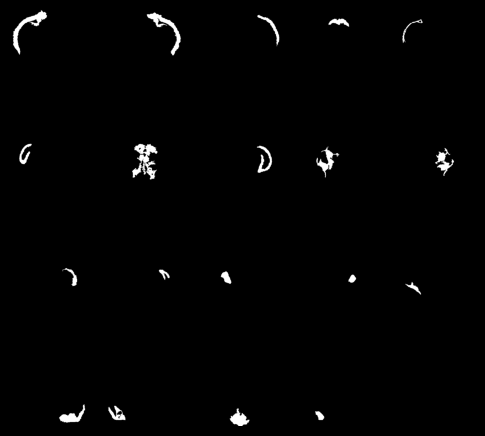

In [8]:
import numpy as np
fig, axs = plt.subplots(4, int(np.ceil(num_components/4)), figsize=(6,6))
axs = axs.flatten()
for i in range(num_components):
    axs[i].imshow(connected_components==(i+1), cmap='gray')
for ax in axs:
    ax.axis('off')
    ax.axis('scaled')
